<a href="https://colab.research.google.com/github/jomin97/project/blob/main/Capstone_project_Jomin_Thomas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.nn.functional as F


# Mounting drive which contains Dataset, Test images, and Models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# License Plate Model class

In [ ]:
import xml.etree.ElementTree as ET

# Define the LicensePlateModel class
class LicensePlateModel(nn.Module):
    def __init__(self):
        super(LicensePlateModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x



# Preprocessing dataset class

In [ ]:
import xml.etree.ElementTree as ET

class LicensePlateDataset(Dataset):
    def __init__(self, image_folder, annotation_folder, transform=None):
        self.image_folder = image_folder
        self.annotation_folder = annotation_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder, self.image_files[idx])
        annotation_path = os.path.join(self.annotation_folder, self.image_files[idx].replace('.png', '.xml'))

        # Load Image
        try:
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            orig_h, orig_w, _ = image.shape
        except Exception as e:
            raise RuntimeError(f"Error reading image: {image_path}, {e}")

        # Load Annotation
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            bbox = root.find('object').find('bndbox')
            x_min = int(bbox.find('xmin').text) / orig_w
            y_min = int(bbox.find('ymin').text) / orig_h
            x_max = int(bbox.find('xmax').text) / orig_w
            y_max = int(bbox.find('ymax').text) / orig_h
            label = torch.tensor([x_min, y_min, x_max, y_max], dtype=torch.float32)
        except Exception as e:
            raise RuntimeError(f"Error reading annotation: {annotation_path}, {e}")

        # Resize Image
        image = cv2.resize(image, (128, 128))
        if self.transform:
            image = self.transform(image)

        return image, label

# Load Dataset

In [ ]:
image_folder = '/content/drive/MyDrive/Dataset/images'
annotation_folder = '/content/drive/MyDrive/Dataset/annotations'

# Transform
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load Dataset
full_dataset = LicensePlateDataset(image_folder, annotation_folder, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training

In [ ]:
# Initialize Model
model = LicensePlateModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation Loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


Epoch [1/50], Loss: 0.0597, Val Loss: 0.0323
Epoch [2/50], Loss: 0.0296, Val Loss: 0.0310
Epoch [3/50], Loss: 0.0248, Val Loss: 0.0256
Epoch [4/50], Loss: 0.0203, Val Loss: 0.0207
Epoch [5/50], Loss: 0.0148, Val Loss: 0.0200
Epoch [6/50], Loss: 0.0110, Val Loss: 0.0181
Epoch [7/50], Loss: 0.0079, Val Loss: 0.0203
Epoch [8/50], Loss: 0.0060, Val Loss: 0.0164
Epoch [9/50], Loss: 0.0038, Val Loss: 0.0158
Epoch [10/50], Loss: 0.0030, Val Loss: 0.0171
Epoch [11/50], Loss: 0.0025, Val Loss: 0.0170
Epoch [12/50], Loss: 0.0020, Val Loss: 0.0147
Epoch [13/50], Loss: 0.0019, Val Loss: 0.0155
Epoch [14/50], Loss: 0.0016, Val Loss: 0.0151
Epoch [15/50], Loss: 0.0013, Val Loss: 0.0160
Epoch [16/50], Loss: 0.0011, Val Loss: 0.0156
Epoch [17/50], Loss: 0.0011, Val Loss: 0.0151
Epoch [18/50], Loss: 0.0011, Val Loss: 0.0163
Epoch [19/50], Loss: 0.0011, Val Loss: 0.0168
Epoch [20/50], Loss: 0.0011, Val Loss: 0.0177
Epoch [21/50], Loss: 0.0013, Val Loss: 0.0179
Epoch [22/50], Loss: 0.0013, Val Loss: 0.01

In [ ]:
# Save the Model
torch.save(model.state_dict(), "license_plate_model.pth")
print()


In [ ]:
# Copying saved model to the drive under Model folder
!cp license_plate_model.pth /content/drive/MyDrive/Model


# Calculate IOU class

In [ ]:
def calculate_iou(box1, box2):

    # Find the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute the area of intersection
    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    # Compute the area of each bounding box
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the area of union
    union = box1_area + box2_area - intersection

    # Compute and return IoU (Intersection over Union)
    return intersection / union if union > 0 else 0


In [ ]:
!pip install easyocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 26.3 MB/s eta 0:00:00


# Recognition and Visualization with Bounding Box and OCR

<ipython-input-19-0d488fe4e66b>:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Model/license_plate_model.pth')) 

Processing /content/drive/MyDrive/Dataset/images/Cars10.png...


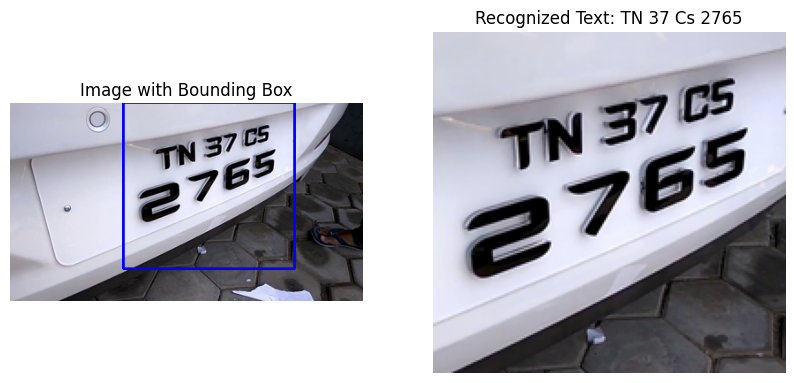

Recognized License Plate Text: TN 37 Cs 2765
Processing /content/drive/MyDrive/Dataset/images/Cars121.png...


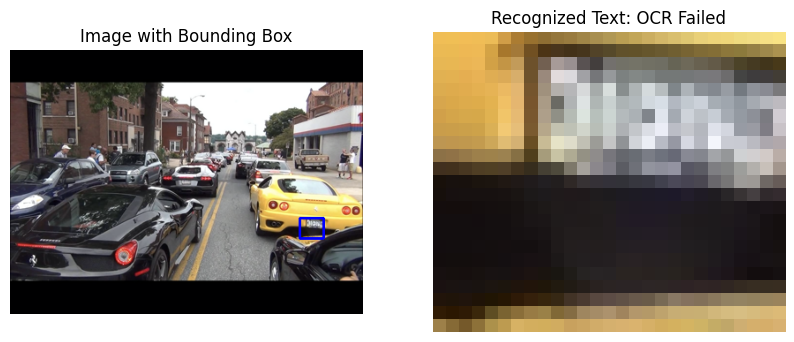

Recognized License Plate Text: OCR Failed
Processing /content/drive/MyDrive/Dataset/images/Cars106.png...


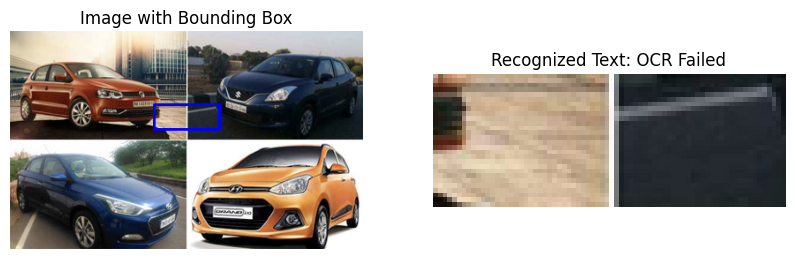

Recognized License Plate Text: OCR Failed
Processing /content/drive/MyDrive/Dataset/images/Cars104.png...


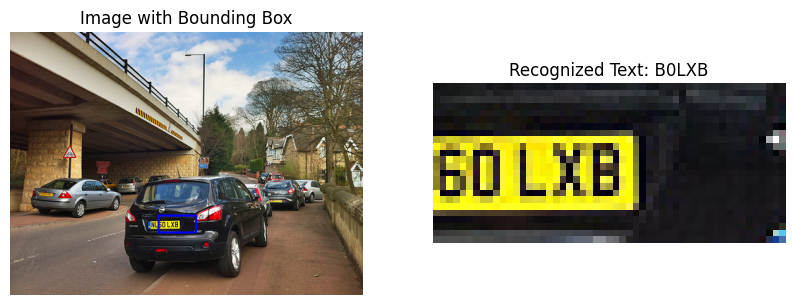

Recognized License Plate Text: B0LXB
Processing /content/drive/MyDrive/Dataset/images/Cars100.png...


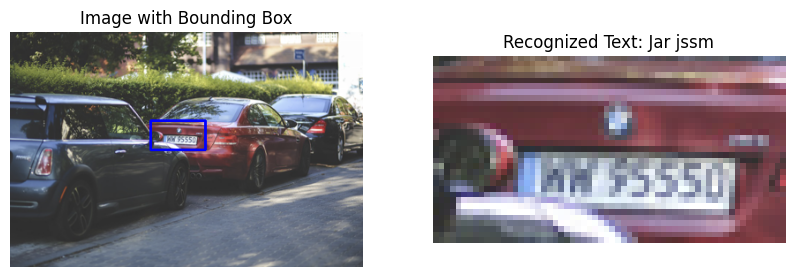

Recognized License Plate Text: Jar jssm
Processing /content/drive/MyDrive/Dataset/images/Cars11.png...


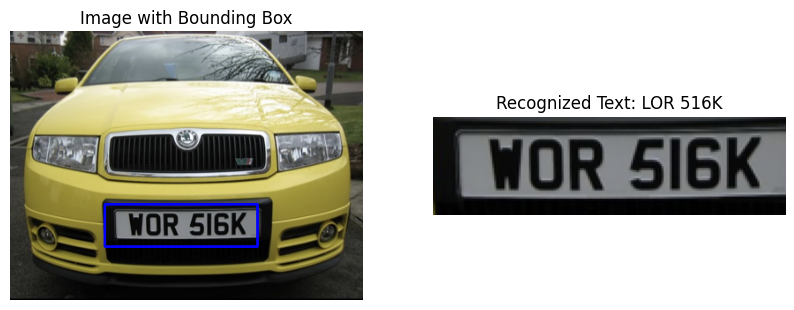

Recognized License Plate Text: LOR 516K
Processing /content/drive/MyDrive/Dataset/images/Cars14.png...


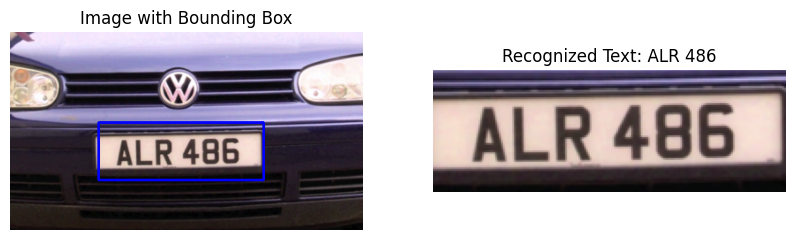

Recognized License Plate Text: ALR 486
Processing /content/drive/MyDrive/Dataset/images/Cars13.png...


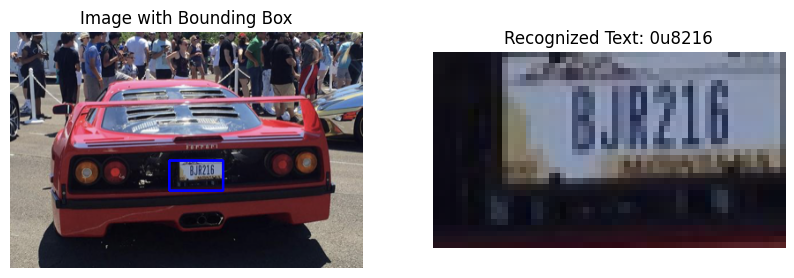

Recognized License Plate Text: 0u8216
Processing /content/drive/MyDrive/Dataset/images/Cars1.png...


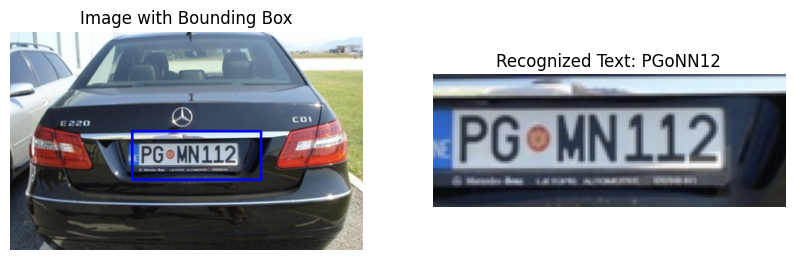

Recognized License Plate Text: PGoNN12
Processing /content/drive/MyDrive/Dataset/images/Cars0.png...


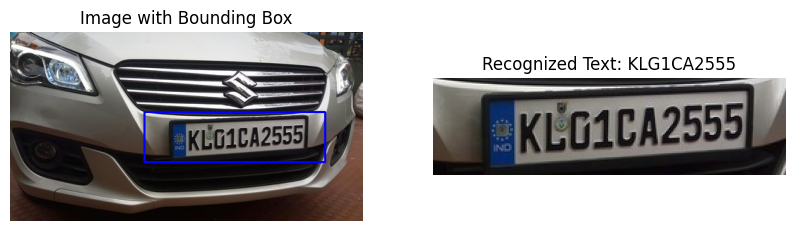

Recognized License Plate Text: KLG1CA2555
Processing /content/drive/MyDrive/Dataset/images/Cars135.png...


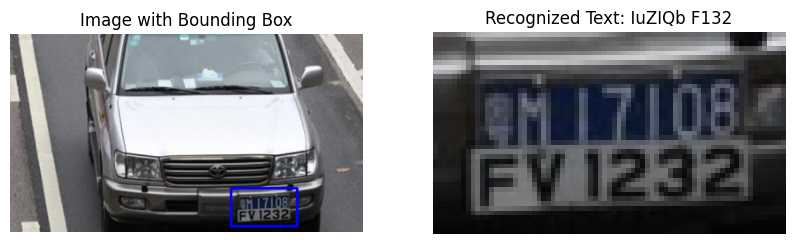

Recognized License Plate Text: IuZIQb F132
Processing /content/drive/MyDrive/Dataset/images/Cars129.png...


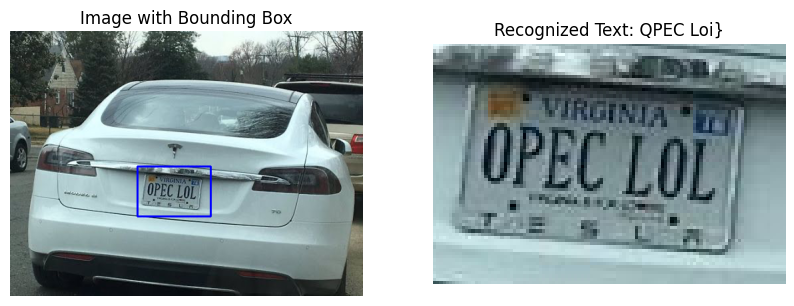

Recognized License Plate Text: QPEC Loi}
Processing /content/drive/MyDrive/Dataset/images/Cars103.png...


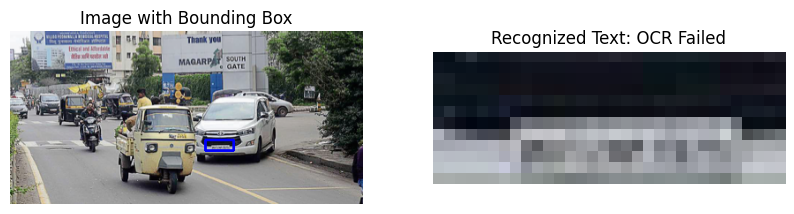

Recognized License Plate Text: OCR Failed
Processing /content/drive/MyDrive/Dataset/images/Cars124.png...


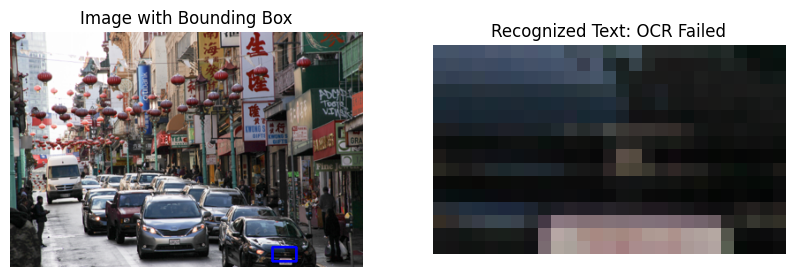

Recognized License Plate Text: OCR Failed
Processing /content/drive/MyDrive/Dataset/images/Cars101.png...


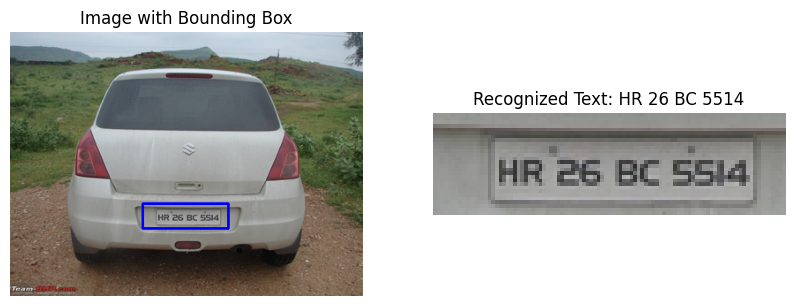

Recognized License Plate Text: HR 26 BC 5514
Processing /content/drive/MyDrive/Dataset/images/Cars111.png...


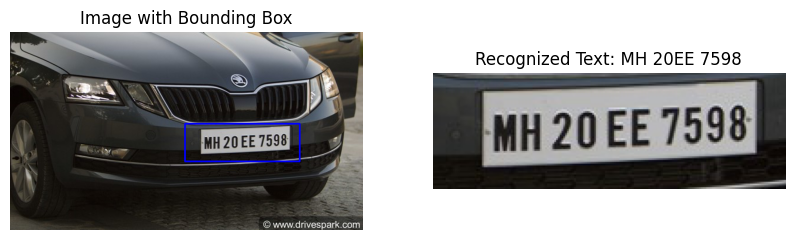

Recognized License Plate Text: MH 20EE 7598
Processing /content/drive/MyDrive/Dataset/images/Cars109.png...


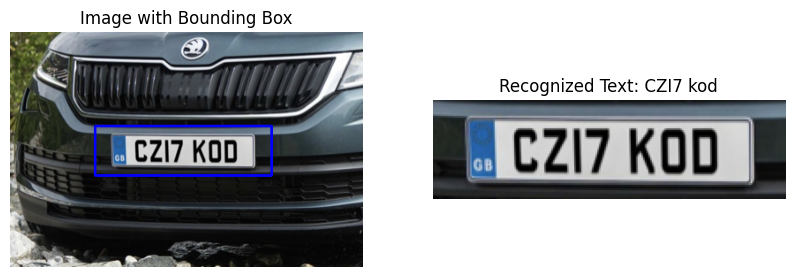

Recognized License Plate Text: CZI7 kod
Processing /content/drive/MyDrive/Dataset/images/Cars108.png...


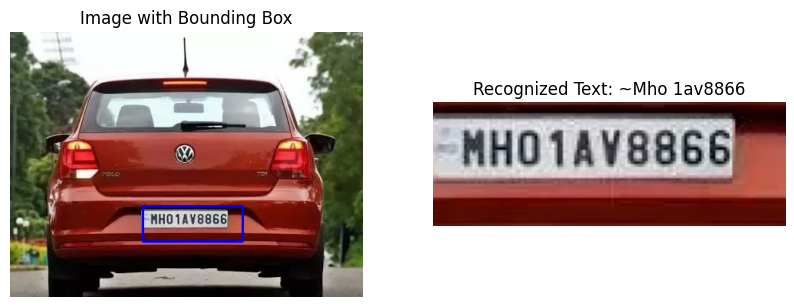

Recognized License Plate Text: ~Mho 1av8866
Processing /content/drive/MyDrive/Dataset/images/Cars118.png...


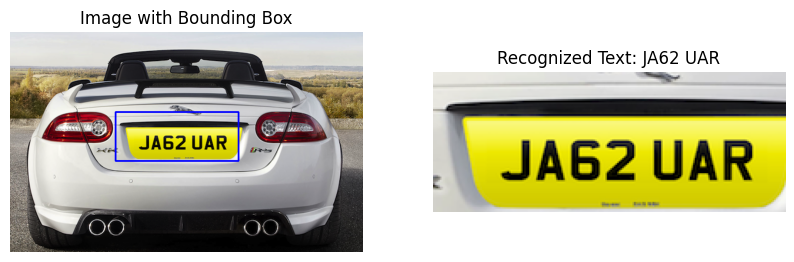

Recognized License Plate Text: JA62 UAR
Processing /content/drive/MyDrive/Dataset/images/Cars132.png...


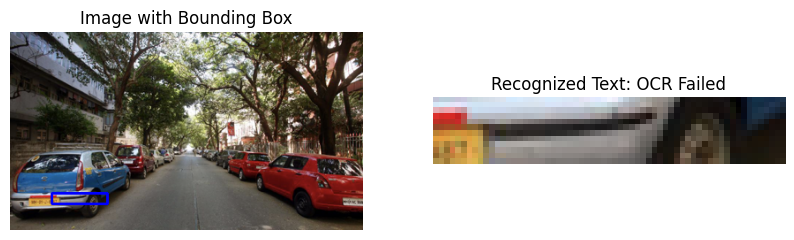

Recognized License Plate Text: OCR Failed


In [ ]:
import os
import cv2
import torch
import matplotlib.pyplot as plt
from easyocr import Reader
import torchvision.transforms as transforms

# Initialize OCR Reader
reader = Reader(['en'])

# Function to predict bounding box and perform OCR dynamically
def recognize_and_visualize(image_path, model, device):
    # Load the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Image at {image_path} could not be loaded.")
        return None

    orig_h, orig_w, _ = image.shape

    # Preprocess the image for the model
    transform = transforms.Compose([transforms.ToTensor()])
    image_resized = cv2.resize(image, (128, 128))
    image_tensor = transform(image_resized).unsqueeze(0).to(device)

    # Predict bounding box using the trained model
    model.eval()
    with torch.no_grad():
        prediction = model(image_tensor).cpu().squeeze().numpy()

    # Rescale prediction back to original image dimensions
    pred_xmin, pred_ymin, pred_xmax, pred_ymax = (
        int(max(0, min(1, prediction[0])) * orig_w),
        int(max(0, min(1, prediction[1])) * orig_h),
        int(max(0, min(1, prediction[2])) * orig_w),
        int(max(0, min(1, prediction[3])) * orig_h),
    )

    # Check if bounding box is valid
    if pred_xmin >= pred_xmax or pred_ymin >= pred_ymax:
        print(f"Invalid bounding box detected for {image_path}: {prediction}")
        return None

    # Adjust the bounding box margins
    margin_y = int((pred_ymax - pred_ymin) * 0.3)
    margin_x = int((pred_xmax - pred_xmin) * 0.1)
    pred_xmin = max(0, pred_xmin - margin_x)
    pred_ymin = max(0, pred_ymin - margin_y)
    pred_xmax = min(orig_w, pred_xmax + margin_x)
    pred_ymax = min(orig_h, pred_ymax + margin_y)

    # Draw the bounding box on the original image
    image_with_box = image.copy()
    cv2.rectangle(
        image_with_box,
        (pred_xmin, pred_ymin),
        (pred_xmax, pred_ymax),
        (255, 0, 0),
        2
    )

    # Crop the license plate from the image
    cropped_plate = image[pred_ymin:pred_ymax, pred_xmin:pred_xmax]

    # Check if the cropped image is valid
    if cropped_plate is None or cropped_plate.size == 0:
        print(f"Warning: Cropped plate is empty or invalid for {image_path}. Adjusting...")
        pred_ymax = min(orig_h, pred_ymax + int(margin_y * 0.5))
        cropped_plate = image[pred_ymin:pred_ymax, pred_xmin:pred_xmax]

    # Run OCR on the cropped license plate
    ocr_results = reader.readtext(cropped_plate, detail=0)
    recognized_text = " ".join(ocr_results) if ocr_results else "OCR Failed"

    # Display the original image with bounding box
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB))
    plt.title("Image with Bounding Box")
    plt.axis("off")

    # Display the cropped license plate with recognized text
    plt.subplot(1, 2, 2)
    if cropped_plate.size != 0:
        plt.imshow(cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2RGB))
    plt.title(f"Recognized Text: {recognized_text}")
    plt.axis("off")
    plt.show()

    return recognized_text

# Paths to images
image_folder = '/content/drive/MyDrive/Dataset/images'
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')]

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LicensePlateModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/Model/license_plate_model.pth'))
model.to(device)

# Range of images to process
start_index = 20
end_index = 40

# Loop through the selected range of images and recognize license plates
for image_path in image_paths[start_index:end_index]:
    print(f"Processing {image_path}...")
    recognized_text = recognize_and_visualize(image_path, model, device)
    if recognized_text:
        print(f"Recognized License Plate Text: {recognized_text}")
    else:
        print(f"Failed to recognize text for {image_path}")


# Evaluate model class

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def evaluate_model(model, test_loader, device, iou_threshold=0.5):
    model.eval()
    all_predictions = []
    all_ground_truths = []
    ious = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.cpu().numpy()
            labels = labels.cpu().numpy()

            for pred, gt in zip(outputs, labels):
                iou = calculate_iou(pred, gt)
                ious.append(iou)
                all_predictions.append(pred)
                all_ground_truths.append(gt)

    # Calculate metrics
    y_true = [1] * len(all_ground_truths)
    y_pred = [1 if iou >= iou_threshold else 0 for iou in ious]

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    mean_iou = np.mean(ious)

    return precision, recall, f1, mean_iou, ious, all_predictions, all_ground_truths


# Performance matrix

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split into train, validation, and test datasets
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes to verify
print(f"Training size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

# Evaluate the model
precision, recall, f1, mean_iou, ious, all_predictions, all_ground_truths = evaluate_model(model, test_loader, device)

# Print metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Mean IoU: {mean_iou:.2f}")


Training size: 303, Validation size: 64, Test size: 66
Precision: 1.00
Recall: 0.88
F1-Score: 0.94
Mean IoU: 0.74


# Visualization of Performance matrix

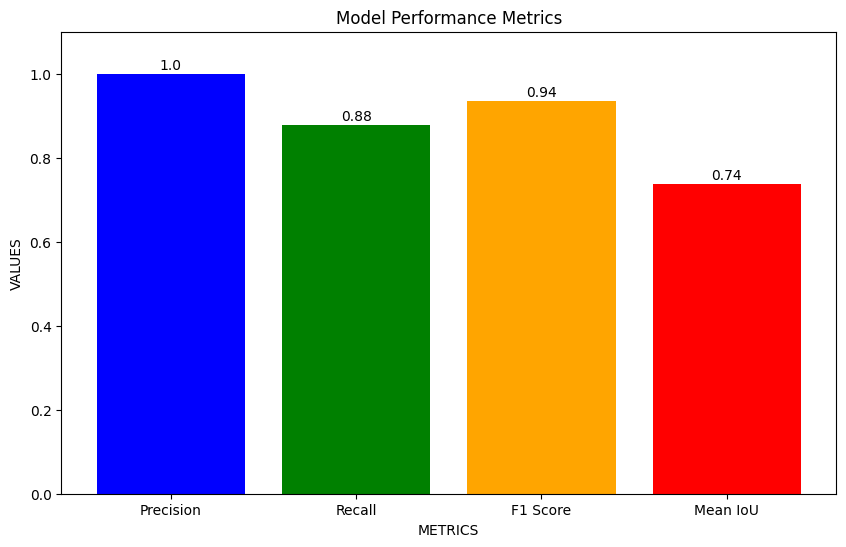

In [ ]:
# Visualize accuracy, precision, recall, f1, mean_iou in one plot
import matplotlib.pyplot as plt

# Store metrics in a list or dictionary
metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Mean IoU': mean_iou
}

# Create a bar plot to visualize the metrics
labels = list(metrics.keys())
values = list(metrics.values())

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'green', 'orange', 'red', 'purple'])

# Add title and labels
plt.title('Model Performance Metrics')
plt.xlabel('METRICS')
plt.ylabel('VALUES')

# Show the value of each bar
for i, v in enumerate(values):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center', color='black')

# Display the plot
plt.ylim(0, 1.1)
plt.show()


# Hyperparameter Tuning

In [ ]:
# Hyperparameter Tuning Block
batch_sizes = [16, 32]
learning_rates = [0.001, 0.0005, 0.0001]
best_val_loss = float('inf')
best_hyperparams = {}
best_epoch = 0

for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"Testing Batch Size: {batch_size}, Learning Rate: {lr}")

        # Create DataLoaders with the current batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize the model, loss function, and optimizer
        model = LicensePlateModel().to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train for a few epochs to evaluate
        for epoch in range(10):
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)

            print(f"Epoch [{epoch+1}/10], Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {avg_val_loss:.4f}")

            # Update best hyperparameters
            if avg_val_loss < best_val_loss:
               best_val_loss = avg_val_loss
               best_epoch = epoch + 1
               best_hyperparams = {'batch_size': batch_size, 'learning_rate': lr}

print(f"Best Hyperparameters: {best_hyperparams}, Best Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch}")


Testing Batch Size: 16, Learning Rate: 0.001
Epoch [1/10], Training Loss: 0.0629, Validation Loss: 0.0288
Epoch [2/10], Training Loss: 0.0309, Validation Loss: 0.0212
Epoch [3/10], Training Loss: 0.0268, Validation Loss: 0.0216
Epoch [4/10], Training Loss: 0.0211, Validation Loss: 0.0185
Epoch [5/10], Training Loss: 0.0153, Validation Loss: 0.0173
Epoch [6/10], Training Loss: 0.0107, Validation Loss: 0.0147
Epoch [7/10], Training Loss: 0.0074, Validation Loss: 0.0146
Epoch [8/10], Training Loss: 0.0053, Validation Loss: 0.0156
Epoch [9/10], Training Loss: 0.0035, Validation Loss: 0.0140
Epoch [10/10], Training Loss: 0.0027, Validation Loss: 0.0147
Testing Batch Size: 16, Learning Rate: 0.0005
Epoch [1/10], Training Loss: 0.0335, Validation Loss: 0.0198
Epoch [2/10], Training Loss: 0.0261, Validation Loss: 0.0180
Epoch [3/10], Training Loss: 0.0198, Validation Loss: 0.0173
Epoch [4/10], Training Loss: 0.0157, Validation Loss: 0.0164
Epoch [5/10], Training Loss: 0.0100, Validation Loss: 

# Training with best hyperparameters

In [ ]:
# Reinitialize DataLoaders and Optimizer with Best Hyperparameters
train_loader = DataLoader(train_dataset, batch_size=best_hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_hyperparams['batch_size'], shuffle=False)
optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['learning_rate'])

# Training Loop with Best Hyperparameters
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


Epoch [1/50], Loss: 0.0043, Val Loss: 0.0122
Epoch [2/50], Loss: 0.0030, Val Loss: 0.0117
Epoch [3/50], Loss: 0.0020, Val Loss: 0.0110
Epoch [4/50], Loss: 0.0021, Val Loss: 0.0110
Epoch [5/50], Loss: 0.0015, Val Loss: 0.0112
Epoch [6/50], Loss: 0.0015, Val Loss: 0.0109
Epoch [7/50], Loss: 0.0014, Val Loss: 0.0109
Epoch [8/50], Loss: 0.0014, Val Loss: 0.0107
Epoch [9/50], Loss: 0.0012, Val Loss: 0.0107
Epoch [10/50], Loss: 0.0011, Val Loss: 0.0109
Epoch [11/50], Loss: 0.0016, Val Loss: 0.0108
Epoch [12/50], Loss: 0.0019, Val Loss: 0.0114
Epoch [13/50], Loss: 0.0014, Val Loss: 0.0105
Epoch [14/50], Loss: 0.0013, Val Loss: 0.0113
Epoch [15/50], Loss: 0.0015, Val Loss: 0.0110
Epoch [16/50], Loss: 0.0014, Val Loss: 0.0113
Epoch [17/50], Loss: 0.0014, Val Loss: 0.0109
Epoch [18/50], Loss: 0.0013, Val Loss: 0.0108
Epoch [19/50], Loss: 0.0018, Val Loss: 0.0109
Epoch [20/50], Loss: 0.0016, Val Loss: 0.0108
Epoch [21/50], Loss: 0.0013, Val Loss: 0.0105
Epoch [22/50], Loss: 0.0013, Val Loss: 0.01

In [ ]:
# Save the best model
torch.save(model.state_dict(), "best_model.pth")
print()

In [ ]:
# Copy the model to the drive
!cp best_model.pth /content/drive/MyDrive/Model

# Evaluation of the best model

In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np


train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split into train, validation, and test datasets
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

test_loader_tuned = DataLoader(test_dataset, batch_size=best_hyperparams['batch_size'], shuffle=True)

model = LicensePlateModel().to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

precision_t, recall_t, f1_t, mean_iou_t, ious_t, all_predictions, all_ground_truths = evaluate_model(model, test_loader_tuned, device)

# Print out the performance metrics
print(f"Precision: {precision_t:.2f}")
print(f"Recall: {recall_t:.2f}")
print(f"F1-Score: {f1_t:.2f}")
print(f"Mean IoU: {mean_iou_t:.2f}")

<ipython-input-108-308457fc161c>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Precision: 1.00
Recall: 0.79
F1-Score: 0.88
Mean IoU: 0.63


# Visualization of the performance matrix comparison

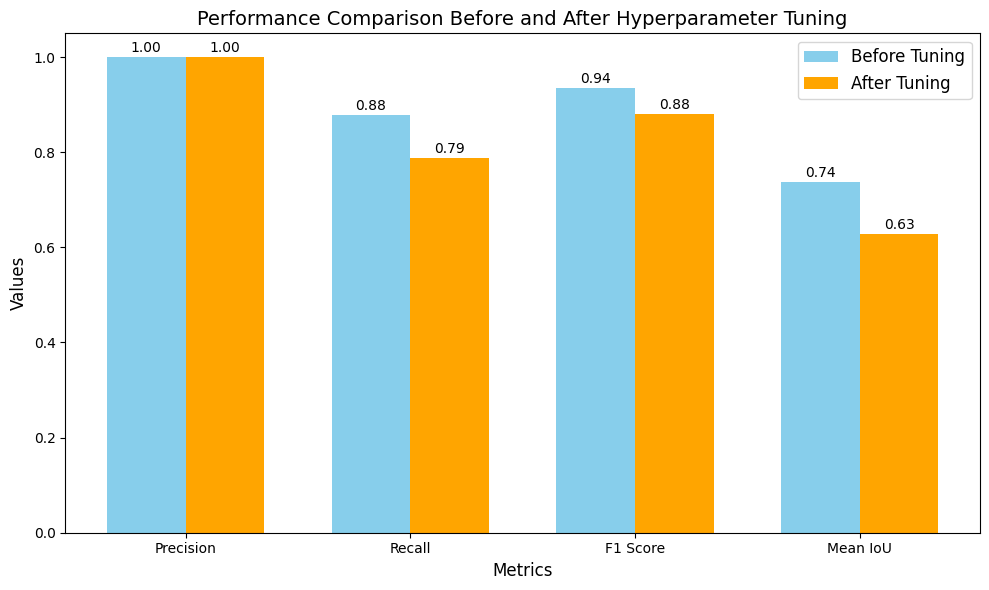

In [ ]:
# Metrics before and after hyperparameter tuning
old_metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Mean IoU': mean_iou
}

new_metrics = {
    'Precision': precision_t,
    'Recall': recall_t,
    'F1 Score': f1_t,
    'Mean IoU': mean_iou_t
}

# Metrics and corresponding values
categories = list(old_metrics.keys())
old_values = list(old_metrics.values())
new_values = list(new_metrics.values())

# Position of bars on x-axis
x = np.arange(len(categories))

# Bar width
bar_width = 0.35

# Plot bars
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width / 2, old_values, bar_width, label='Before Tuning', color='skyblue')
plt.bar(x + bar_width / 2, new_values, bar_width, label='After Tuning', color='orange')

# Add labels, title, and legend
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Performance Comparison Before and After Hyperparameter Tuning', fontsize=14)
plt.xticks(x, categories, fontsize=10)
plt.legend(fontsize=12)

# Add value labels on the bars
for i in range(len(categories)):
    plt.text(x[i] - bar_width / 2, old_values[i] + 0.01, f"{old_values[i]:.2f}", ha='center', fontsize=10)
    plt.text(x[i] + bar_width / 2, new_values[i] + 0.01, f"{new_values[i]:.2f}", ha='center', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


# Model testing with images outside the dataset in the test folder(license_plate_model)

<ipython-input-84-40cac0da4f87>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Model/license_plate_model.pth'))


Starting Final Model Testing...
Processing /content/drive/MyDrive/Test/test 3.jpg...


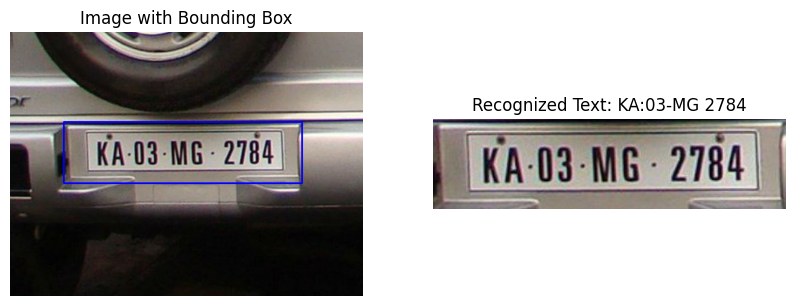

Recognized License Plate Text: KA:03-MG 2784
Processing /content/drive/MyDrive/Test/test 2.jpg...


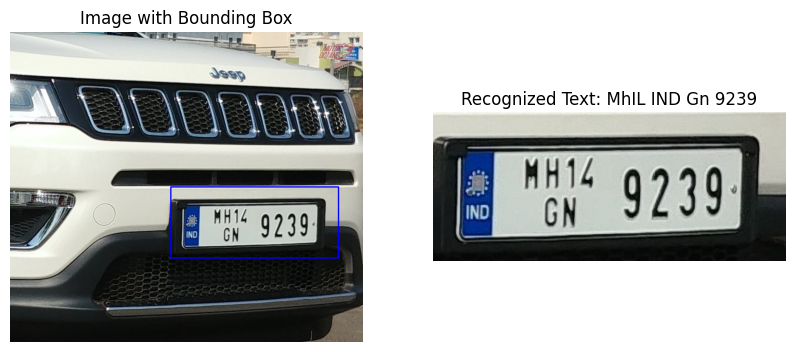

Recognized License Plate Text: MhIL IND Gn 9239
Processing /content/drive/MyDrive/Test/test 1.jpg...


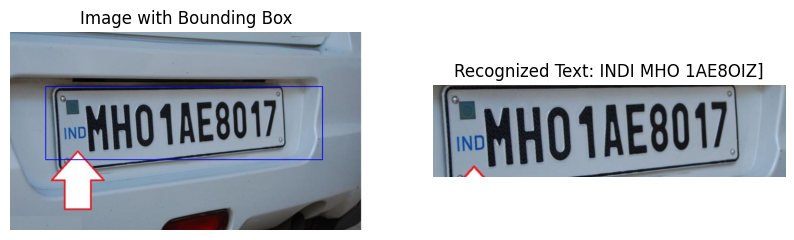

Recognized License Plate Text: INDI MHO 1AE8OIZ]


In [ ]:
# Paths to the test images folder
test_image_folder = '/content/drive/MyDrive/Test'
test_image_paths = [os.path.join(test_image_folder, f) for f in os.listdir(test_image_folder) if f.endswith('.jpg')]

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LicensePlateModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/Model/license_plate_model.pth'))
model.to(device)

# Loop through the test images and recognize license plates
print("Starting Final Model Testing...")
for image_path in test_image_paths:
    print(f"Processing {image_path}...")
    recognized_text = recognize_and_visualize(image_path, model, device)
    if recognized_text:
        print(f"Recognized License Plate Text: {recognized_text}")
    else:
        print(f"Failed to recognize text for {image_path}")


# Model testing with images outside the dataset in the test folder(best_model)

<ipython-input-85-eb144232c893>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Model/best_model.pth'))


Starting Final Model Testing...
Processing /content/drive/MyDrive/Test/test 3.jpg...


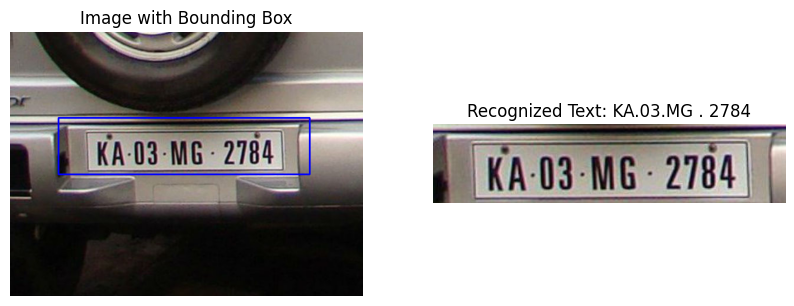

Recognized License Plate Text: KA.03.MG . 2784
Processing /content/drive/MyDrive/Test/test 2.jpg...


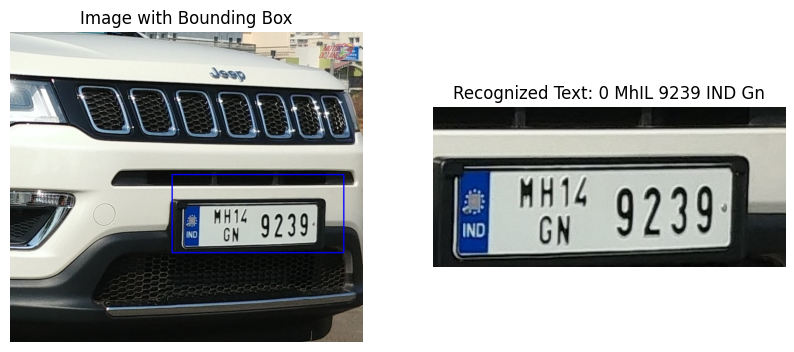

Recognized License Plate Text: 0 MhIL 9239 IND Gn
Processing /content/drive/MyDrive/Test/test 1.jpg...


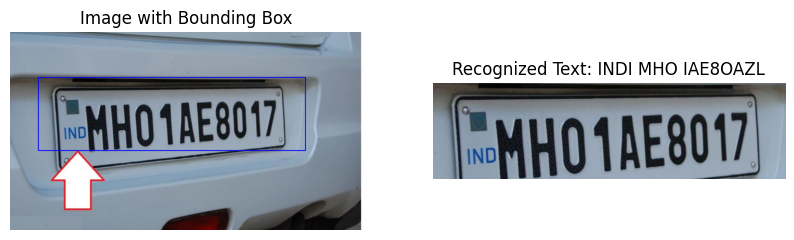

Recognized License Plate Text: INDI MHO IAE8OAZL


In [ ]:
# Paths to the test images folder
test_image_folder = '/content/drive/MyDrive/Test'
test_image_paths = [os.path.join(test_image_folder, f) for f in os.listdir(test_image_folder) if f.endswith('.jpg')]

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LicensePlateModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/Model/best_model.pth'))
model.to(device)

# Loop through the test images and recognize license plates
print("Starting Final Model Testing...")
for image_path in test_image_paths:
    print(f"Processing {image_path}...")
    recognized_text = recognize_and_visualize(image_path, model, device)
    if recognized_text:
        print(f"Recognized License Plate Text: {recognized_text}")
    else:
        print(f"Failed to recognize text for {image_path}")
